In [1]:
# Base ----------------------------------
import pandas as pd
import geopandas as gpd #remember to install Geopandas:: conda install --channel conda-forge geopandas

# GeoDataframe / Maps manipulation packages 
from shapely.geometry import Point #to convert coordinates of dataframe to geometry point of a geodataframe 
from shapely.geometry import LineString #to convert coordinates of dataframe to geometry line (joining 2 points) of a geodataframe

# Viz ------------------------------------
import matplotlib.pyplot as plt

# Reto: Asignación de las estaciones meteorológicas a cada municipio 

**Objetivo: Tenemos 102 estaciones meteorológicas, y cada una de esas estaciones debe ser asignada a uno de los 112 Municipios de la Provincia de Vizcaya.** Nota: una estación meteorológica puede compartir varios Municipios



**Supuestos:**


* Tomaremos las coordenadas del centro de cada Municipio como punto de referencia, ya que representa una posición central media de la zona.


* Utilizaremos la proyección Mercator (EPSG:25830) con coordenadas en UTM porque:
    - Los datos del cliente ya están en UTM;
    - Trabajar en UTM dará resultados de distancia en metros directamente;
    - Esta proyección es buena para el análisis a gran escala


**Nota:** Para una mayor precisión podríamos utilizar la proyección PlateCarree (EPSG:32663), diseñada específicamente para conservar las distancias en un mapa.
(Esta tarea aún está pendiente y sólo veríamos pequeñas diferencias en los valores absolutos, que desde una perspectiva de negocios no requerimos para este ejercicio).


# Racional / Motor

La idea será utilizar GeoPandas para resolver este problema donde podemos utilizar los métodos de la librería para calcular distancias e iterar sobre ellas, evitando así tener que pasar por un proceso muy manual y generando mayor precisión. Necesitamos

- 1) Un **Geodataframe** con un objeto geométrico conformado para los **Municipios de Vizcaya** (que ya tenemos de Maps Exploration)


- 2) Un **Geodataframe** con un objeto geométrico de forma para las **Estaciones meteorológicas** (sólo tenemos un fichero CSV con las coordenadas UTM de las estaciones meteorológicas, por lo que tendremos que crear nuestro propio Geodataframe)

Comience por importar los datos.

Traducción realizada con la versión gratuita del traductor www.DeepL.com/Translator

## Provincia de Vizcaya GDF / Shapefile 

**Carga el mapa de España y el País Vasco, ya que puede ser útil**

In [2]:
# Municipality shapefile (that we can read as GeoDataFrame) that we have already worked with before to get the maps
biscay_gdf = gpd.read_file('../Other_open_data/shapefiles/biscay/geodataframe_biscay_municipalities.shp')

In [3]:
biscay_gdf.rename({"municipali":"municipality","code_munic":"code_municipality"}, axis=1, inplace=True)

In [4]:
'''Agregue las coordenadas para el centro del Municipio y tómelo como el punto central promedio de la región
   Esto se usará como la calculadora de distancia (como recomienda JC)'''

biscay_gdf["UTM_points"] = biscay_gdf.geometry.centroid 

In [5]:
#inspection of Biscay GDF
biscay_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   municipality       112 non-null    object  
 1   code_municipality  112 non-null    object  
 2   geometry           112 non-null    geometry
 3   UTM_points         112 non-null    geometry
dtypes: geometry(2), object(2)
memory usage: 3.6+ KB


## Estaciones meteorológicas GDF / Shapefile

In [6]:
# Load the stations CSV we have from client, we will need to work this into a GeoDataFrame
stations_df = pd.read_csv("../Input_open_data/ds05_LOCALIZACION-ESTACIONES-METEOROLOGICAS.csv",sep=";")

#Convert column names to lower case for practical reason
stations_df.columns = stations_df.columns.str.lower()

#Set index as Stations, Station Code and Station type and because it will be useful to get the closest municipality
stations_df.set_index(["estacion","codigo","tipo"], inplace=True)

Now create a new column that will use the Point method from package shapely.geometry 

In [7]:
stations_df["UTM_points"] = [Point(x, y) for x, y in zip(stations_df.xutm, stations_df.yutm)]

Convertirlo en un Geodataframe para poder hacer nuestros cálculos deseados (distancias de puntos).

In [8]:
#Create a GeoDataFrame that can be saved as Shapefile and Inspect it
stations_gdf = gpd.GeoDataFrame(stations_df, crs="EPSG:25830", geometry=stations_df.UTM_points)
stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 102 entries, ('Abetxuko', 'C076', 'A') to ('Zizurkil', 'C029', 'M')
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   xutm        102 non-null    int64   
 1   yutm        102 non-null    int64   
 2   cota (m)    102 non-null    int64   
 3   UTM_points  102 non-null    object  
 4   geometry    102 non-null    geometry
dtypes: geometry(1), int64(3), object(1)
memory usage: 16.1+ KB


In [9]:
stations_gdf.head()

,,,xutm,yutm,cota (m),UTM_points,geometry
estacion,codigo,tipo,,,,,
Abetxuko,C076,A,527154,4747039,510,POINT (527154 4747039),POINT (527154.000 4747039.000)
Alegria,C056,A,538992,4743676,545,POINT (538992 4743676),POINT (538992.000 4743676.000)
Altube,C035,M,510880,4757063,618,POINT (510880 4757063),POINT (510880.000 4757063.000)
Antoñana,C0A3,A,549965,4725290,573,POINT (549965 4725290),POINT (549965.000 4725290.000)
Arkaute,C001,M,530608,4744631,517,POINT (530608 4744631),POINT (530608.000 4744631.000)


In [12]:
stations_gdf.to_file("estaciones_metereologicas_UTM", driver='ESRI Shapefile')

ValueError: Invalid field type <class 'shapely.geometry.point.Point'>

In [13]:
stations_gdf.to_csv('stations_gdf.csv') 

## Visualización rápida de datos de las estaciones meteorológicas frente a los municipios  

Trace los 2 Geodataframes para obtener una imagen de cuántas Meteo Estaciones de nuestro conjunto de datos tenemos que se encuentran dentro de la región de Vizcaya.

- Podemos ver claramente que la mayoría de las Meteo Estaciones se encuentran fuera de la provincia de Vizcaya
- Podemos confirmar que sólo 30 estaciones se encuentran dentro de la provincia de Vizcaya

In [14]:
# Load Basque Country GDF / Shapefile so we can:
# add texture to the map and it does not plot blank areas for Weather Stations that lie outside Biscay Province

#Load Spain Map GeoDataframe & Set projection to UTM (same as we have in our map exploration)
spain_provinces_gdf = gpd.read_file("../Other_open_data/shapefiles/spain/gadm36_ESP_2.shx")
spain_provinces_gdf.to_crs("EPSG:25830",inplace=True)
spain_provinces_gdf.set_crs("EPSG:25830",inplace=True)

# Slice GeoDataframe for Basque Country only
basque_country_gdf = spain_provinces_gdf.loc[spain_provinces_gdf.NAME_1 == "País Vasco",:]
# Slice GeoDataFrame for surrounding regions (it gives nicer maps plots)
surrounding_regions_gdf = spain_provinces_gdf.loc[spain_provinces_gdf.NAME_1.isin(["Cantabria","País Vasco","Castilla y León"]),:]

##############################################################################################################
# Save the sliced GDFs to shapefiles that we can use later if needed for other maps explorations (only used 1)

basque_country_gdf.to_file("basque_country_UTM", driver='ESRI Shapefile')
#surrounding_regions_gdf.to_file("cantabria_paisvasco_castillayleon_UTM", driver='ESRI Shapefile')

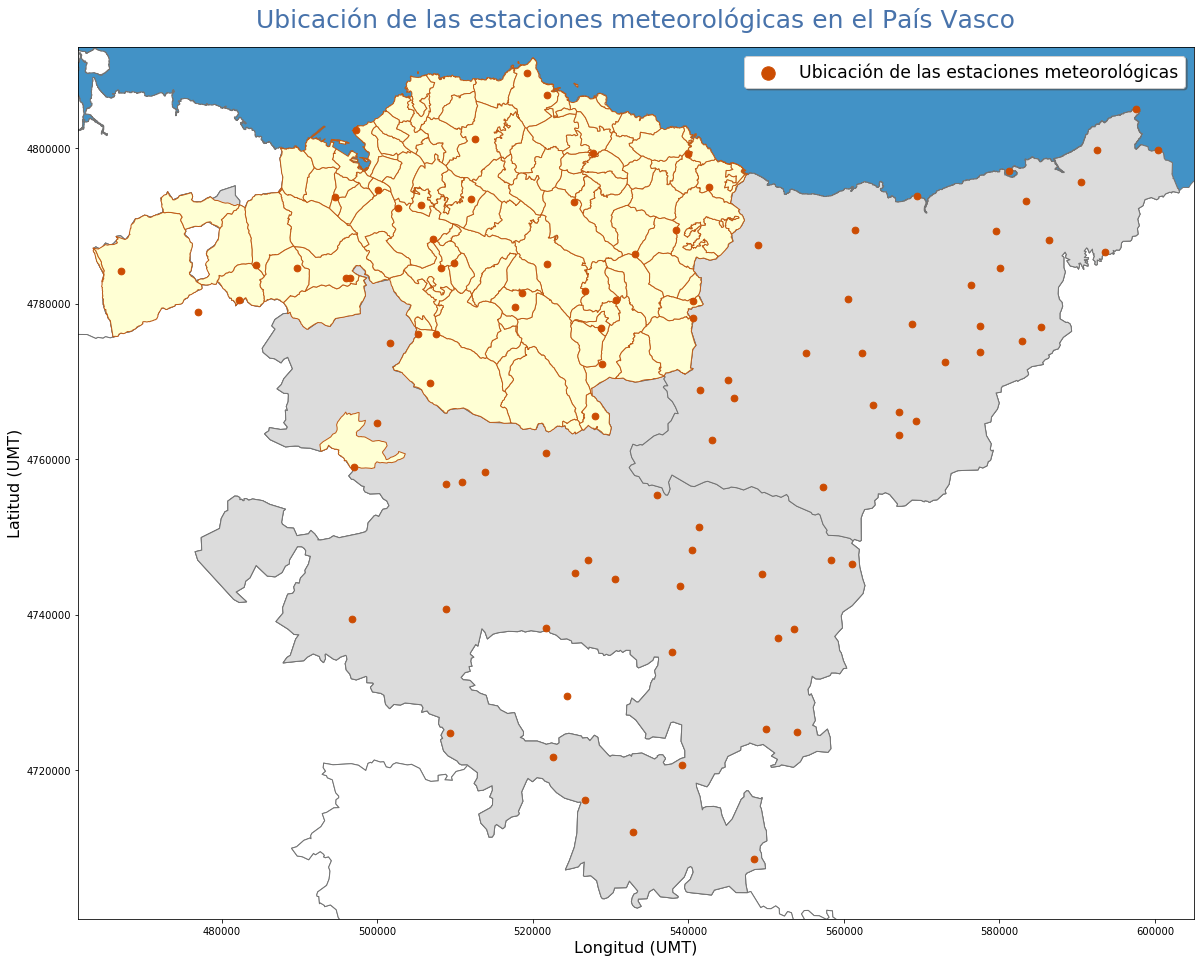

<Figure size 432x288 with 0 Axes>

In [15]:
# Create Basemap of Basque Country
ax = basque_country_gdf.plot(figsize=(20, 20), zorder=2, color='gainsboro', edgecolor='#737373')
# Add layer of Spain Map for more texture.
spain_provinces_gdf.plot(zorder=1, color='White', edgecolor='#737373', ax=ax)

# Create base map of Biscay Provinces
biscay_gdf.geometry.plot(zorder=3, color='#ffffd4', edgecolor='#bf5b17', ax=ax)

# Add wasp locations map
stations_gdf.plot(label="Ubicación de las estaciones meteorológicas", color='#cc4c02', zorder=4, markersize=45, ax=ax)

# Set legends
ax.legend(loc='best', shadow=True, fontsize='xx-large', markerscale = 2)

# Set axis titles
ax.set_title('Ubicación de las estaciones meteorológicas en el País Vasco', 
             pad = 20, 
             fontdict={'fontsize':25, 'color': '#4873ab'})
ax.set_xlabel('Longitud (UMT)', fontdict={'fontsize':16})  
ax.set_ylabel('Latitud (UMT)',fontdict={'fontsize':16})
ax.set_xlim(461500, 605000)
ax.set_ylim(4700900, 4813000)
ax.set_facecolor('#4292c6')

plt.show()
plt.savefig('../img/estaciones_metereologicas.png')

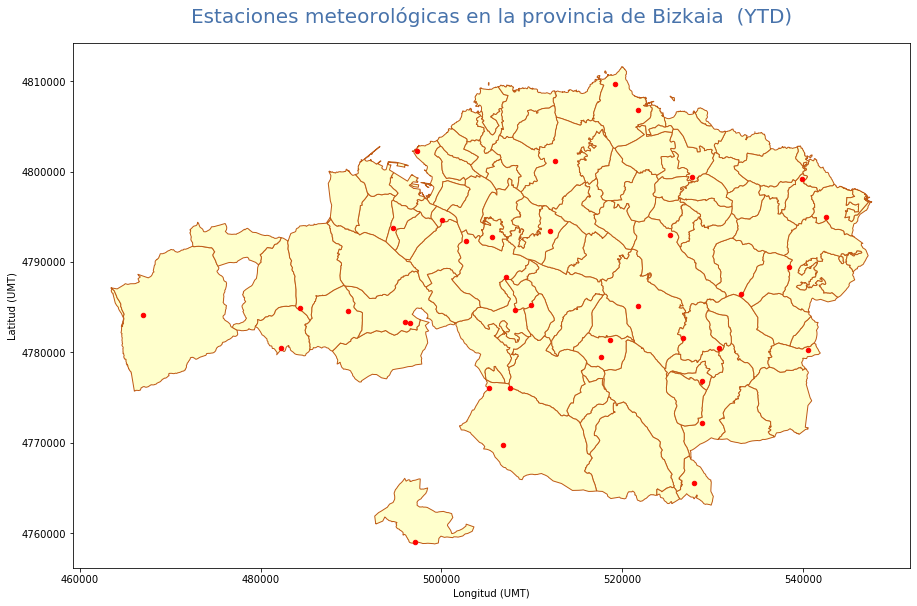

<Figure size 432x288 with 0 Axes>

In [16]:
stations_gdf_clipped = gpd.clip(stations_gdf, biscay_gdf)

# Create base map of Biscay Provinces
ax = biscay_gdf.geometry.plot(figsize=(15, 15), zorder=1, color='#ffffcc', edgecolor='#bf5b17')

# Add wasp locations map
stations_gdf_clipped.plot(label="Ubicación de las estaciones meteorológicas", color='red', zorder=5, markersize=20, ax=ax)

# Set axis titles
ax.set_title('Estaciones meteorológicas en la provincia de Bizkaia  (YTD)', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud (UMT)')  
ax.set_ylabel('Latitud (UMT)')


plt.show()
plt.show()
plt.savefig('../img/estaciones_metereologicas_bizkaia.png')

## La plantilla real del script de Python para asignar las estaciones meteorológicas 

Ahora que tenemos ambos GeoDataFrames necesitamos calcular los puntos de distancia utilizando el método .distance(). 

Lo probamos para el 1º Municipio del GeoDataFrame de Bizkaia.

1 ) Para el primer Municipio (Gordexola) en el GeoDataFrame del Municipio de Vizcaya (la posición del índice 0),

2 ) Calculamos las distancias entre todas las estaciones y encontramos el índice de la estación con el valor más bajo. 

In [17]:
stations_gdf.distance(biscay_gdf.loc[0, "UTM_points"]) 
## De la salida confirmamos que crea una serie con las distancias de todas las estaciones para Gordexola (índice basado en 0) del municipio.

estacion     codigo  tipo
Abetxuko     C076    A       47118.839918
Alegria      C056    A       58226.972602
Altube       C035    M       28790.288680
Antoñana     C0A3    A       78634.759748
Arkaute      C001    M       51276.090597
                                 ...     
Santa Clara  C007    M       89363.593514
Urkulu       C0D0    A       52601.232018
Zarautz      C064    M       77140.475141
Zegama       C028    M       68035.852395
Zizurkil     C029    M       82887.027187
Length: 102, dtype: float64

In [18]:
biscay_gordexola = stations_gdf.distance(biscay_gdf.loc[0, "UTM_points"]).idxmin()
biscay_gordexola
#De la serie seleccionamos la de mínima distancia.
#La salida muestra que la estación más cercana para Gordexola es Sodupe-Herrerias.

('Sodupe-Cadagua', 'C0C3', 'C')

- Ahora que tenemos la fórmula para 1 Municipio, queremos iterar a través de todos los municipios para no tener que ir 1 a 1 a través de todos los 112.**


- Creamos un bucle For que nos dará las distancias mínimas de todos los municipios.

In [19]:
'''Crea un bucle for para iterar por cada Minicipio.

El bucle calcula 
1) la distancia de cada estación para i0(Gordexola) y dando el índice de la estación donde se minimiza la distancia, 
2) luego la distancia de cada estación para i1(Gexto) y dando el índice de la estación donde se minimiza la distancia
3) etc... hasta llegar al final del GeoDataFrame del Municipio que tiene 1 único Municipio como Índice'''

closest_stations_list = []
for i in biscay_gdf.UTM_points:
    closest_stations_list.append(stations_gdf.geometry.distance(i).idxmin())

'''
IDEA PARA CORREGIR LAS ESTACIONES METEOROLÓGICAS CON VALORES PERDIDOS:

lista_de_estaciones_más_cercanas = []
for i in biscay_gdf.UTM_points:
    estación_más_cercana_i = estaciones_gdf.geometría.distancia(i).nsmallest(n=2,keep="primera").index
    si estación_más_cercana_i[0][1] no está en WBds02_METEO.csv.station_code.values:   #######confirmar/comprobar esta línea
        closest_stations_list.append(closest_station_i[1])
    si no:
        closest_stations_list.append(closest_station_i[0])
''' 
    
# Create a new series with the new list                                 
closest_stations_series = pd.Series(closest_stations_list,name="closest_station")

# Add the newly created Series as a new column for each Municipality showing the closest station                                 
biscay_gdf["closest_station"] = closest_stations_series  

In [20]:
# Manually replace the station that does not exist in WBds02_METEO.csv

# first find the index for the Municipality to assign a new station
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Zaratamo"),"UTM_points"])
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Basauri"),"UTM_points"])
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Galdakao"),"UTM_points"])

# then extract the 2nd closest weather station
biscay_zaratamo_48097 = stations_gdf.distance(biscay_gdf.loc[97, "UTM_points"]).nsmallest(n=2).index[1]
biscay_basauri_48015 = stations_gdf.distance(biscay_gdf.loc[23, "UTM_points"]).nsmallest(n=2).index[1]
biscay_galdakao_48036 = stations_gdf.distance(biscay_gdf.loc[41, "UTM_points"]).nsmallest(n=2).index[1]

# then replace the value in the DataFrame to later save as a .csv file
biscay_gdf.at[97,"closest_station"] = biscay_zaratamo_48097
biscay_gdf.at[23,"closest_station"] = biscay_basauri_48015
biscay_gdf.at[41,"closest_station"] = biscay_galdakao_48036

97    POINT (510759.931 4783835.490)
Name: UTM_points, dtype: geometry
23    POINT (509085.637 4786507.059)
Name: UTM_points, dtype: geometry
41    POINT (513424.801 4786444.656)
Name: UTM_points, dtype: geometry


Use the same code to add a new column with the distance (for checking purposes).

In [21]:
#Aquí el bucle está calculando para cada municipio la distancia de las estaciones y dando sólo la distancia mínima

distance_stations_list = []
for i in biscay_gdf.UTM_points:
    distance_stations_list.append(round(stations_gdf.geometry.distance(i).min(),0))

'''
Hay que comprobar cómo se obtiene la distancia mínima, tal vez utilizando la columna "estación más cercana" creada anteriormente y encontrándola
en el gdf de estaciones
''' 
   
    
# Create a new series with the new list                                 
distance_stations_series = pd.Series(distance_stations_list,name="station_distance(meters)")

# The newly created Series as a new column for each Municipality showing the closest station                                 
biscay_gdf["station_distance(meters)"] = distance_stations_series.astype(int)  

In [22]:
# Reemplazar manualmente la estación que no existe en WBds02_METEO.csv

# first find the index for the Municipality to assign a new station
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Zaratamo"),"UTM_points"])
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Basauri"),"UTM_points"])
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Galdakao"),"UTM_points"])

# then extract the 2nd closest weather station
biscay_zaratamo_48097_dis = round(stations_gdf.distance(biscay_gdf.loc[97, "UTM_points"]).nsmallest(n=2)[1],0)
biscay_basauri_48015_dis = round(stations_gdf.distance(biscay_gdf.loc[23, "UTM_points"]).nsmallest(n=2)[1],0)
biscay_galdakao_48036_dis = round(stations_gdf.distance(biscay_gdf.loc[41, "UTM_points"]).nsmallest(n=2)[1],0)

# then replace the value in the DataFrame to later save as a .csv file
biscay_gdf.at[97,"station_distance(meters)"] = biscay_zaratamo_48097_dis
biscay_gdf.at[23,"station_distance(meters)"] = biscay_basauri_48015_dis
biscay_gdf.at[41,"station_distance(meters)"] = biscay_galdakao_48036_dis

97    POINT (510759.931 4783835.490)
Name: UTM_points, dtype: geometry
23    POINT (509085.637 4786507.059)
Name: UTM_points, dtype: geometry
41    POINT (513424.801 4786444.656)
Name: UTM_points, dtype: geometry


Utilice el mismo código para añadir una nueva serie con el número de estaciones que se encuentran dentro de cada Municipio, utilizando el método .within().

In [23]:
#Aquí el bucle está calculando para cada municipio la suma de las estaciones que están dentro del municipio

number_stations_list = []
for i in biscay_gdf.geometry:
    number_stations_list.append(stations_gdf.geometry.within(i).sum())

# Create a new series with the new list                                 
number_stations_series = pd.Series(number_stations_list,name="number_stations")

# The newly created Series as a new column for each Municipality showing the closest station                                 
biscay_gdf["number_of_stations"] = number_stations_series  

Utiliza el mismo código para añadir una nueva serie con las coordenadas de las estaciones más cercanas para cada municipio con el fin de mapearlas y poder comprobar si las distancias calculadas parecen correctas.

In [24]:
closest_stations_coords_list = []
for i in biscay_gdf.UTM_points:
    closest_stations_coords_list.append(stations_gdf.loc[stations_gdf.geometry.distance(i).idxmin(),"geometry"])

# Create a new series with the new list                                 
closest_stations_coords_series = gpd.GeoSeries(closest_stations_coords_list)

# The newly created Series as a new column for each Municipality showing the closest station                                 
biscay_gdf["closest_station_UTM"] = closest_stations_coords_series

In [25]:
# Reemplazar manualmente la estación que no existe en WBds02_METEO.csv

# first find the index for the Municipality to assign a new station
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Zaratamo"),"UTM_points"])
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Basauri"),"UTM_points"])
print(biscay_gdf.loc[biscay_gdf.municipality.str.contains("Galdakao"),"UTM_points"])

# then extract the 2nd closest weather station
biscay_zaratamo_48097_point = stations_gdf.loc[stations_gdf.distance(biscay_gdf.loc[97, "UTM_points"]).nsmallest(n=2).index,"geometry"].iloc[1]
biscay_basauri_48015_point = stations_gdf.loc[stations_gdf.distance(biscay_gdf.loc[23, "UTM_points"]).nsmallest(n=2).index,"geometry"].iloc[1]
biscay_galdakao_48036_point = stations_gdf.loc[stations_gdf.distance(biscay_gdf.loc[41, "UTM_points"]).nsmallest(n=2).index,"geometry"].iloc[1]

# then replace the value in the DataFrame to later save as a .csv file
biscay_gdf.at[97,"closest_station_UTM"] = biscay_zaratamo_48097_point
biscay_gdf.at[23,"closest_station_UTM"] = biscay_basauri_48015_point
biscay_gdf.at[41,"closest_station_UTM"] = biscay_galdakao_48036_point

97    POINT (510759.931 4783835.490)
Name: UTM_points, dtype: geometry
23    POINT (509085.637 4786507.059)
Name: UTM_points, dtype: geometry
41    POINT (513424.801 4786444.656)
Name: UTM_points, dtype: geometry


In [26]:
# check if the replaced values for C0B2 look to have worked properly
biscay_gdf.loc[biscay_gdf.code_municipality.isin(["48097","48015","48036"]),:]

,municipality,code_municipality,geometry,UTM_points,closest_station,station_distance(meters),number_of_stations,closest_station_UTM
23,Basauri,48015,"POLYGON ((507040.444 4788116.240, 507103.318 4...",POINT (509085.637 4786507.059),"(Venta Alta, C037, M)",2089,1,POINT (508142.000 4784643.000)
41,Galdakao,48036,"POLYGON ((509369.317 4788055.076, 509373.411 4...",POINT (513424.801 4786444.656),"(Venta Alta, C037, M)",5582,0,POINT (508142.000 4784643.000)
97,Zaratamo,48097,"POLYGON ((509283.274 4784812.407, 509291.274 4...",POINT (510759.931 4783835.490),"(Venta Alta, C037, M)",2740,0,POINT (508142.000 4784643.000)


## Guardar el CSV con las nuevas estaciones meteorológicas asignadas para cada municipio

Finalmente, guarda el archivo csv para subirlo a Github y mantener el mismo formato actual cortando y adaptando el layot de formato actual.  

In [27]:
# Save file as CSV to replace WBds01_weather2municipality.csv
  
    # 1st) extract station_code to maintain same format as Github csv
biscay_gdf.closest_station = biscay_gdf.closest_station.apply(str)
station_code = biscay_gdf.closest_station.str.split(", ", n=3, expand=True)
station_code = station_code.iloc[:,1].str.replace("'","")
station_code = pd.Series(station_code, name="station_code")
         # insert station_code series in biscay_gdf
biscay_gdf["station_code"] = station_code
         # rename municipality code column to maintain same format as csv file
biscay_gdf.rename({"code_municipality":"municip_code"}, axis=1, inplace=True)

   # 2nd) create DataFrame that has the same format as the csv file in Github with the new stations assigned to a Municipality
WBds01_weather2municipality = pd.DataFrame(data = biscay_gdf, columns= ["station_code","municip_code"])
WBds01_weather2municipality.sort_values(by="municip_code", ascending=True, inplace=True)

In [29]:
WBds01_weather2municipality.head()

,station_code,municip_code
5,C0B7,48001
8,C061,48002
9,C079,48003
14,C0BA,48004
6,C032,48005


In [28]:
 # 3rd) save the new csv file
WBds01_weather2municipality.to_csv("WBds01_GEO.csv", index=False)

## Doble comprobación / detección de errores

### Inspeccionar el GDF recién creado y realizar algunas comprobaciones

In [30]:
biscay_gdf.info()
biscay_gdf

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   municipality              112 non-null    object  
 1   municip_code              112 non-null    object  
 2   geometry                  112 non-null    geometry
 3   UTM_points                112 non-null    geometry
 4   closest_station           112 non-null    object  
 5   station_distance(meters)  112 non-null    int64   
 6   number_of_stations        112 non-null    int64   
 7   closest_station_UTM       112 non-null    geometry
 8   station_code              112 non-null    object  
dtypes: geometry(3), int64(2), object(4)
memory usage: 8.0+ KB


,municipality,municip_code,geometry,UTM_points,closest_station,station_distance(meters),number_of_stations,closest_station_UTM,station_code
0,Gordexola,48042,"POLYGON ((487947.088 4780148.287, 488034.090 4...",POINT (493491.640 4780009.147),"('Sodupe-Cadagua', 'C0C3', 'C')",4148,0,POINT (495995.000 4783316.000),C0C3
1,Gorliz,48043,"MULTIPOLYGON (((504445.350 4806653.836, 504405...",POINT (505447.088 4807205.581),"('Mungia', 'C057', 'A')",9326,0,POINT (512568.000 4801183.000),C057
2,Getxo,48044,"POLYGON ((498376.525 4796994.975, 498467.430 4...",POINT (499224.060 4800321.020),"('Punta Galea', 'C042', 'M')",2788,1,POINT (497270.000 4802310.000),C042
3,Güeñes,48045,"POLYGON ((489233.038 4787422.027, 489427.436 4...",POINT (495145.130 4784959.026),"('Sodupe-Cadagua', 'C0C3', 'C')",1850,2,POINT (495995.000 4783316.000),C0C3
4,Gernika-Lumo,48046,"POLYGON ((522896.955 4795034.525, 523049.949 4...",POINT (524974.366 4795556.861),"('Muxika', 'C063', 'C')",2550,0,POINT (525328.000 4793031.000),C063
...,...,...,...,...,...,...,...,...,...
107,Ziortza-Bolibar,48915,"POLYGON ((533160.054 4786090.330, 533187.775 4...",POINT (536170.705 4788170.758),"('Iruzubieta', 'C0BD', 'A')",2614,0,POINT (538474.000 4789407.000),C0BD
108,Sondika,48904,"POLYGON ((504309.854 4792760.768, 504328.338 4...",POINT (505715.673 4793041.335),"('Sangroniz', 'C0B9', 'A')",332,1,POINT (505614.000 4792725.000),C0B9
109,Zamudio,48905,"POLYGON ((507306.799 4792491.898, 507311.840 4...",POINT (510815.923 4792777.957),"('Derio', 'C003', 'M')",1338,1,POINT (512000.000 4793400.000),C003
110,Forua,48906,"POLYGON ((523424.472 4797541.966, 523477.754 4...",POINT (525372.760 4798184.389),"('Arteaga', 'C002', 'M')",2706,0,POINT (527783.000 4799414.000),C002


In [31]:
# Guradamos

biscay_gdf.to_csv("weather_to_municp.csv", index=False)

In [32]:
# si está vacía, no hay ningún municipio asignado a la estación C0B2 (que no está presente en nuestro conjunto de datos METEO)
biscay_gdf.loc[biscay_gdf.station_code.str.contains("C0B2"),:]

,municipality,municip_code,geometry,UTM_points,closest_station,station_distance(meters),number_of_stations,closest_station_UTM,station_code


### Trazar el resultado en un mapa

- Haz una comprobación rápida para ver si funciona correctamente, trazando las distancias en un mapa.


- JC sugiere utilizarlo para EDA 

In [33]:
#Generate a new GDF with index as Municipalities to be able to groupby

biscay_gdf2 = biscay_gdf.set_index("municipality")

#Get the Closest Stations Geometry Coordinate Points
station_points_gdf = biscay_gdf2.closest_station_UTM

#Get the Municipality's average center Coordinate Points
municipality_points_gdf = biscay_gdf2.UTM_points

#Append in a new Dataframe to then groupby and generate using the Linestrings method 
#lines from Municipality center point to the Stations Point
path_df = station_points_gdf.append(municipality_points_gdf)

#Groupby Municipality and Get the LineString to have a path object
path_df = path_df.groupby(by="municipality").apply(list).apply(lambda x: LineString(x)).reset_index()

#Columns is empty so rename it to "geometry"
path_df.rename({0:"geometry"},axis=1,inplace=True)

#Set the geometry column as type Geometry & the CRS to "EPSG:25830" (same as other projections)
path_gdf = gpd.GeoDataFrame(path_df, geometry=path_df.geometry)
path_gdf.crs = "EPSG:25830"

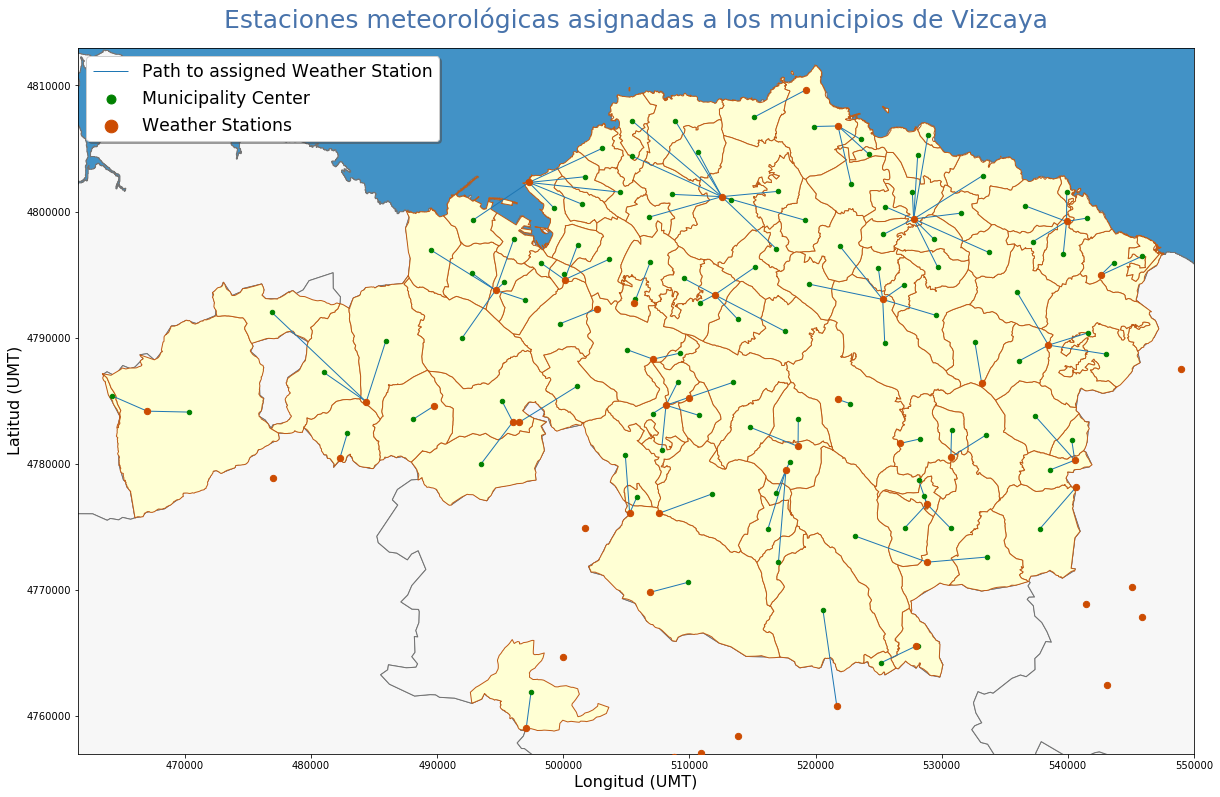

In [34]:
# Set basemaps
ax = biscay_gdf.plot(figsize=(20, 20), zorder=2, color='#ffffd4', edgecolor='#bf5b17')
surrounding_regions_gdf.plot(zorder=1, color='#f7f7f7', edgecolor='#737373', ax=ax)

# Set results plots
path_gdf.plot(label="Path to assigned Weather Station", zorder=2,linestyle='-', linewidth=1, ax=ax)
municipality_points_gdf.plot(label="Municipality Center", color='green',markersize=20, zorder=3, ax=ax)
stations_gdf.plot(label="Weather Stations", color='#cc4c02',markersize=40, zorder=4, ax=ax)

# Set legends
ax.legend(loc='upper left', shadow=True, fontsize='xx-large', markerscale = 2)

# Set axis titles
ax.set_title('Estaciones meteorológicas asignadas a los municipios de Vizcaya', 
             pad = 20, 
             fontdict={'fontsize':25, 'color': '#4873ab'})
ax.set_xlabel('Longitud (UMT)', fontdict={'fontsize':16})  
ax.set_ylabel('Latitud (UMT)',fontdict={'fontsize':16})
ax.set_xlim(461500, 550000)
ax.set_ylim(4757000, 4813000)
ax.set_facecolor('#4292c6')

plt.plot()
plt.savefig("../img/assigned_weather_stations_map.png")